# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import numpy as np
import pandas as pd

import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в верхней части ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

## Подготовка данных

### Первчиный осмотр

Выгрузим данные и посмотрим случайные десять строк исходной таблицы.

In [2]:
df = pd.read_csv('S:/kaggle/autos.csv')

In [3]:
df.sample(n=10, replace=True, random_state=42)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
121958,2016-03-18 23:06:16,9999,small,2014,manual,69,500,30000,11,petrol,fiat,no,2016-03-18 00:00:00,0,56321,2016-04-06 19:45:11
146867,2016-03-22 05:36:17,4444,sedan,2004,manual,150,3er,150000,2,gasoline,bmw,no,2016-03-22 00:00:00,0,51069,2016-03-22 08:46:23
131932,2016-03-27 17:52:44,12525,sedan,2004,manual,192,5er,150000,6,petrol,bmw,no,2016-03-27 00:00:00,0,90530,2016-04-05 14:16:22
259178,2016-04-02 00:47:21,4690,NaN,2017,manual,105,astra,125000,8,petrol,opel,no,2016-04-01 00:00:00,0,9526,2016-04-06 04:16:31
119879,2016-03-20 13:42:09,200,small,1998,manual,50,polo,150000,10,petrol,volkswagen,yes,2016-03-20 00:00:00,0,35099,2016-04-06 14:44:24
110268,2016-04-03 10:37:58,13600,wagon,2007,auto,286,3er,150000,10,gasoline,bmw,no,2016-04-03 00:00:00,0,84419,2016-04-07 11:17:16
207892,2016-04-04 20:55:25,7900,sedan,2008,manual,75,beetle,50000,7,petrol,volkswagen,no,2016-04-04 00:00:00,0,99334,2016-04-06 23:18:08
54886,2016-03-12 15:41:16,3300,small,2007,manual,68,2_reihe,150000,7,gasoline,peugeot,NaN,2016-03-12 00:00:00,0,59427,2016-03-21 22:19:11
137337,2016-03-05 18:53:58,700,coupe,2001,manual,107,megane,150000,5,petrol,renault,no,2016-03-05 00:00:00,0,71083,2016-04-03 02:46:45
87498,2016-03-06 12:44:22,4000,NaN,2010,manual,86,logan,40000,0,gasoline,dacia,NaN,2016-03-06 00:00:00,0,98617,2016-04-06 05:45:23


**Признаки**:

* ***DateCrawled*** — дата скачивания анкеты из базы
* ***VehicleType*** — тип автомобильного кузова
* ***RegistrationYear*** — год регистрации автомобиля
* ***Gearbox*** — тип коробки передач
* ***Power*** — мощность (л. с.)
* ***Model*** — модель автомобиля
* ***Kilometer*** — пробег (км)
* ***RegistrationMonth*** — месяц регистрации автомобиля
* ***FuelType*** — тип топлива
* ***Brand*** — марка автомобиля
* ***NotRepaired*** — была машина в ремонте или нет
* ***DateCreated*** — дата создания анкеты
* ***NumberOfPictures*** — количество фотографий автомобиля
* ***PostalCode*** — почтовый индекс владельца анкеты (пользователя)
* ***LastSeen*** — дата последней активности пользователя

**Целевой признак**:

* ***Price*** — цена (евро)

**Наблюдение №1:**

- В ряде столбцов наблюдаются пропуски, которые необходимо обработать.
- Признак ***NumberOfPictures*** на первый взгляд содержит только нули.

In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Наблюдение №2:**

- Минимальное значение ***Price*** равняется нулю, что выглядит всема странно.
- Аналогичная ситуация наблюдается в переменных ***Power*** и ***RegistrationMonth***. 
- Среднеквадратичное значение некторых переменных имеет порядок, аналогичный как и у среднего значения, что указывает на разброс оных.
- Максимальные значения признаков - ***RegistrationYear*** и ***Power*** так же стоит обработать.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Наблюдение №3:**

- Большое количество пропусков в переменное ***NotRepaired***.
- Типы данных численных переменных в исходной таблице имеют оптимальный формат - **int64**.

### Обработка пропусков

Перед обработкой пропусков удалим столбцы, которые никак не помогут на этапах анализа и обучения моделей.

In [6]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

Оценим состояние наших данных. Выведем основную информацию по пропускам и дубликатам. 

In [7]:
def pre_process_data(data):
    
    columns_number = data.shape[1]
    columns_with_nan = (data.isna().sum()!=0).sum()
    columns_with_duplicates = (data.duplicated().sum()!=0).sum()
    rows_number = data.shape[0]
    
    nan_sum = data.isna().sum().sum()
    nan_percent = nan_sum / (data.shape[0] * data.shape[1])
    
    duplicates_sum = data.duplicated().sum()
    duplicates_percent = duplicates_sum / (data.shape[0] * data.shape[1])

    print('Количество столбцов в таблице: {}'.format(columns_number))
    print('Количество строк в таблице: {}'.format(rows_number))
    print('Количество столбцов с пропусками: {}'.format(columns_with_nan))
    print('Количество столбцов с дубликатами: {}'.format(columns_with_duplicates))
    print('Суммарное число пропусков: {}'.format(nan_sum))
    print('Процент пропусков: {:.2%}'.format(nan_percent))
    print('Суммарное число дубликатов: {}'.format(duplicates_sum))
    print('Процент дубликатов: {:.2%}'.format(duplicates_percent))

In [8]:
def nan_plot(data):
    
    perc_of_nan = pd.DataFrame(data.isna().mean().sort_values(ascending=False)*100)
    perc_of_nan.columns = ['percent']
    perc_of_nan.dropna()
    perc_of_nan = perc_of_nan[perc_of_nan['percent']!=0]
    
    f, ax = plt.subplots(figsize=(10, 7))
    
    sns.barplot(x='percent',
                y=perc_of_nan.index,
                data=perc_of_nan,
                color='#56B4E9')

    plt.title('Bar Plot of NaN')
    plt.xlabel('Percent of NaN, %')
    plt.ylabel('Variable')
    plt.show()
    
    return perc_of_nan

In [9]:
pre_process_data(df)

Количество столбцов в таблице: 11
Количество строк в таблице: 354369
Количество столбцов с пропусками: 5
Количество столбцов с дубликатами: 1
Суммарное число пропусков: 181077
Процент пропусков: 4.65%
Суммарное число дубликатов: 27543
Процент дубликатов: 0.71%


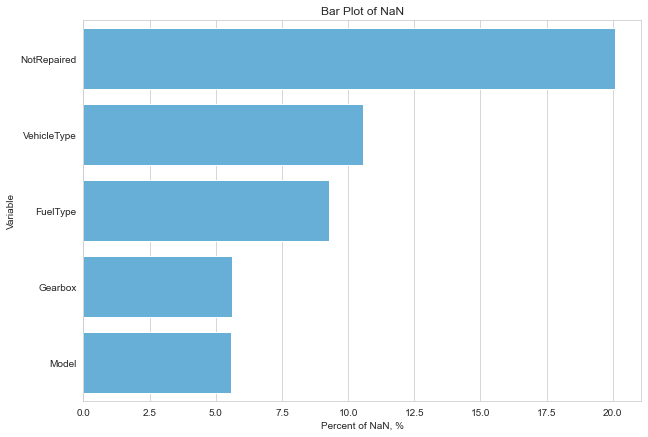

,percent
NotRepaired,20.079070
VehicleType,10.579368
FuelType,9.282697
Gearbox,5.596709
Model,5.560588


In [10]:
nan_plot(df)

#### Model

Посмотрим, на строки, содержащие пропуски в переменной ***Model***.

In [11]:
df.loc[df['Model'].isna()].sample(n=5, replace=True, random_state=42)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
282523,4900,NaN,2005,manual,150,NaN,150000,11,NaN,bmw,no
16382,4300,NaN,2016,manual,90,NaN,80000,0,NaN,opel,no
97304,850,sedan,1996,manual,170,NaN,150000,0,lpg,bmw,yes
213786,0,wagon,1999,manual,97,NaN,150000,7,NaN,nissan,NaN
201151,890,small,1995,manual,75,NaN,150000,0,petrol,volkswagen,no


На первый взгляд сложно выявить какую-либо зависимость между в пропусками в рассматриваемом признаке и остальными переменными. Создадим метку, обозначающую пропуск в зависимости от бренда машины.

In [12]:
%%time

for i in df['Brand'].unique():
    
    df.loc[(df['Brand']==i) & (df['Model'].isna()), 'Model'] = ('unk_'+i)

Wall time: 1.23 s


#### VehicleType

Посмотрим на пропуски в переменной ***VehicleType***.

In [13]:
df.loc[df['VehicleType'].isna()].sample(n=5, replace=True, random_state=42)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
150288,500,NaN,2000,NaN,0,seicento,150000,0,NaN,fiat,NaN
7684,280,NaN,2016,manual,50,polo,150000,11,cng,volkswagen,NaN
107609,600,NaN,1995,manual,75,astra,150000,0,petrol,opel,no
59033,1600,NaN,2016,manual,0,a_klasse,125000,11,NaN,mercedes_benz,no
160093,16900,NaN,2012,auto,204,golf,125000,5,gasoline,volkswagen,NaN


Взаимосвязь между пропусками в данном признаке с остальными признаками выявить не удалось. Заполним пропуски в соответсвие с моделями авто, ведь у каждой модели может быть только один тип автомобильного кузова.

In [14]:
%%time

for i, j in df.pivot_table(index=['Model', 'VehicleType']).index:
    
    df.loc[(df['Model']==i) & (df['VehicleType'].isna()), 'VehicleType']=j

Wall time: 42.5 s


#### FuelType

Оценим данные с пропусками в графе с типом топлива.

In [15]:
df.loc[df['FuelType'].isna()].sample(n=5, replace=True, random_state=42)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
169235,1400,bus,2005,NaN,0,unk_hyundai,150000,3,NaN,hyundai,NaN
8953,6500,sedan,2004,manual,177,5er,150000,12,NaN,bmw,NaN
121196,100,convertible,1500,NaN,0,g_klasse,5000,0,NaN,mercedes_benz,NaN
66479,3800,bus,2017,manual,77,jazz,150000,12,NaN,honda,no
180240,3990,convertible,2015,NaN,0,unk_porsche,5000,0,NaN,porsche,NaN


Так же заполним пропуски в соответсвие с моделью.

In [16]:
%%time

for i, j in df.pivot_table(index=['Model', 'FuelType']).index:
    
    df.loc[(df['Model']==i) & (df['FuelType'].isna()), 'FuelType']=j

Wall time: 29.5 s


#### Gearbox	

Может есть какая-то зависимость в пропусках в **Gearbox** с остальными данными.

In [17]:
df.loc[df['Gearbox'].isna()].sample(n=5, replace=True, random_state=42)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
283166,1400,bus,2017,NaN,75,golf,150000,4,cng,volkswagen,NaN
15645,5500,bus,2006,NaN,0,passat,150000,0,petrol,volkswagen,NaN
96723,2950,small,2007,NaN,0,c1,150000,3,petrol,citroen,no
213608,0,bus,2008,NaN,0,unk_audi,5000,0,cng,audi,NaN
201768,1000,sedan,1990,NaN,109,e_klasse,150000,12,petrol,mercedes_benz,no


Предположим, что одна модель машины может обладать только одной комплектацией коробки передач.

In [18]:
%%time

for i, j in df.pivot_table(index=['Model', 'Gearbox']).index:
    
    df.loc[(df['Model']==i) & (df['Gearbox'].isna()), 'Gearbox']=j

Wall time: 17.6 s


#### NotRepaired

Посмотрим на пропуски в **NotRepaired**.

In [19]:
df.loc[df['NotRepaired'].isna()].sample(n=5, replace=True, random_state=42)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
78446,650,wagon,1996,manual,150,3er,150000,11,petrol,bmw,NaN
4257,500,bus,2000,manual,101,passat,150000,0,cng,volkswagen,NaN
273269,1099,sedan,2002,manual,0,156,150000,9,gasoline,alfa_romeo,NaN
30963,1300,bus,2017,auto,82,a_klasse,150000,6,petrol,mercedes_benz,NaN
184949,260,other,1996,auto,60,other,150000,5,petrol,ford,NaN


Для обработки пропусков создадим сводную таблицу по моделяи и средней цене в зависимости от наличия ремонта. Предположим, что машины, прошедшие ремонт стоят дешевле.

In [20]:
pivot_nan = df.pivot_table(index='Model', columns='NotRepaired', values='Price', aggfunc='mean')

Заполним пропуски исходя из созданной сводной таблицы.

In [21]:
%%time

for i in pivot_nan.index:
    
    df.loc[((df['NotRepaired'].isna()) & (df['Model']==i) & (df['Price']>pivot_nan['no'][i])), 'NotRepaired']='no'
    df.loc[((df['NotRepaired'].isna()) & (df['Model']==i) & (df['Price']<pivot_nan['no'][i])), 'NotRepaired']='yes'

Wall time: 18.4 s


#### Проверка заполнения пропусков

Вновь выведем иформацию по пропускам.

In [22]:
pre_process_data(df)

Количество столбцов в таблице: 11
Количество строк в таблице: 354369
Количество столбцов с пропусками: 1
Количество столбцов с дубликатами: 1
Суммарное число пропусков: 3
Процент пропусков: 0.00%
Суммарное число дубликатов: 29218
Процент дубликатов: 0.75%


У нас осталось несколько пропусков, от которых так же избавимся.

In [23]:
df = df.dropna()

### Обработка дубликатов

Так как в исходных данных у нас крайне мало дубликатов, то их можно просто отбросить. 

In [24]:
df = df.drop_duplicates()

### Поиск аномалий 

Посмотрим распределение представленных численных переменных.

In [25]:
def plot_hist(data, column):

    f, (ax_box, ax_hist) = plt.subplots(2,
                                        sharex=True,
                                        gridspec_kw={'height_ratios': (.15, .85)},
                                        figsize=(8, 5))

    sns.distplot(data[column],
                 hist=True,
                 kde=False, 
                 bins=24,
                 hist_kws={'edgecolor':'black'})
    sns.boxplot(data[column],
                ax=ax_box) 

    ax_box.set(xlabel='')
    
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title('{} distribution with hist'.format(column))
    
    plt.show()

In [26]:
numerical_features = ['Price', 'Power', 'Kilometer', 'RegistrationYear', 'RegistrationMonth']

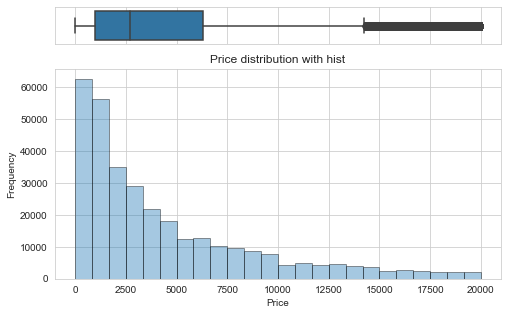

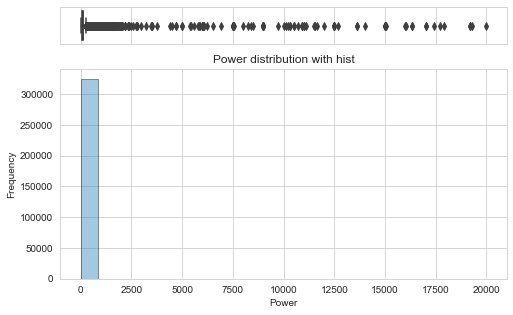

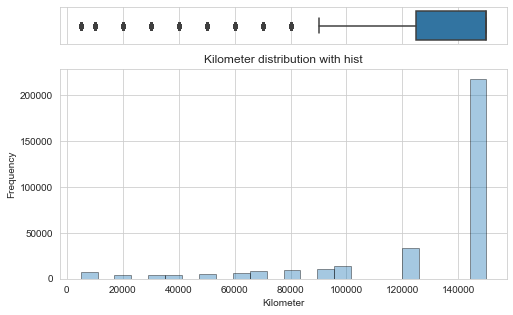

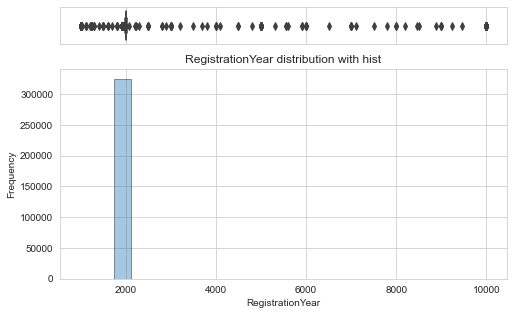

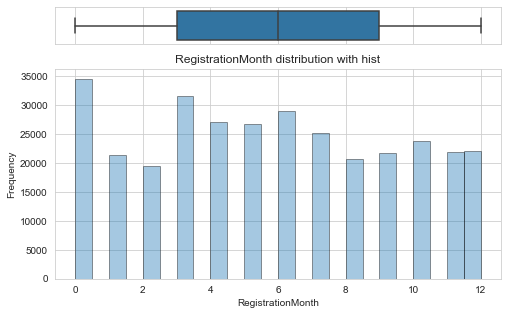

In [27]:
for i in numerical_features:
    plot_hist(df, i)

Допустим, что цена на машину может быть любой, как и пробег, а вот мощность двигателя следует обработать. Данный признак имеет логнормальное распределение. Ограничимся полуторным интерквантильным интервалом, помимо это. Предположим, что стоимость не может быть равна нулю. Так же обработаем и ***RegistrationMonth*** и ***RegistrationYear***, где присутствует подозрительный значения.

In [28]:
def scale(col):
    
    desc = df[col].describe()
    iqr = desc[6] - desc[4]
    
    left_scale = round(desc[4] - 1.5 * iqr, 2)
    right_scale = round(desc[6] + 1.5 * iqr, 2)
    
    if left_scale < desc[3]:
        left_scale = desc[3] 
        
    if left_scale > desc[7]:
        right_scale = desc[7]
        
    return [left_scale, right_scale]

In [29]:
df = df[(df['Power']>=scale('Power')[0]) &
        (df['Power']<=scale('Power')[1]) &
        (df['Power']!=0) &
        (df['Price']!=0) &
        (df['RegistrationMonth']!=0) &
        (df['RegistrationYear']>=scale('RegistrationYear')[0]) &
        (df['RegistrationYear']<=scale('RegistrationYear')[1])]

In [30]:
df.shape

(252498, 11)

In [31]:
def class_ration(data):
    
    ratio = data.value_counts(normalize = 1)
    shape = data.shape
    
    plt.figure(figsize = (9, 5))
    
    plt.bar(ratio.index, ratio)
    
    plt.xticks(ratio.index, ratio.index.values)
    plt.ylabel('Frequency')
    plt.title('Class Ratio')
    
    plt.show()
    
    print('Размерность выборки: \n{}'.format(shape))

    print('Соотношение классов выборки: \n{}'.format(ratio))

Оценим распределения на обработанных данных.

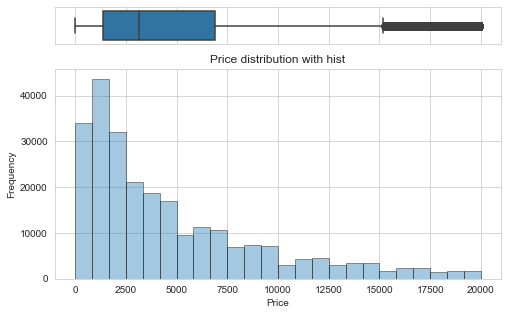

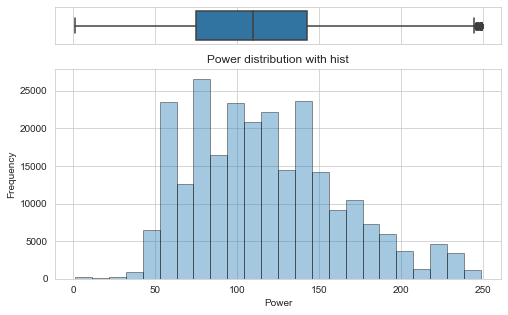

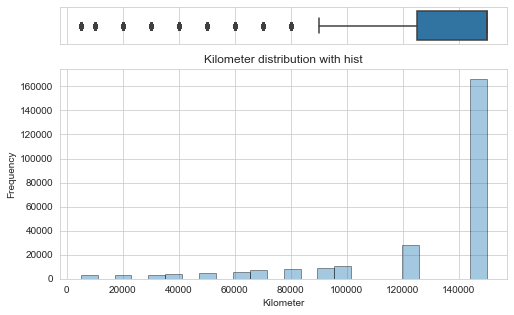

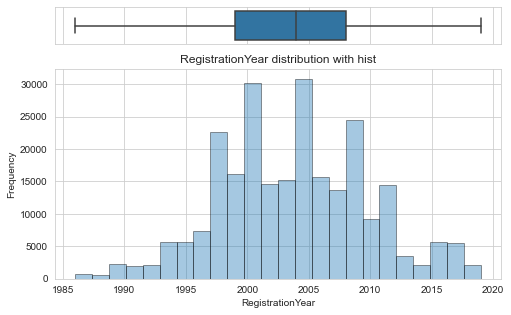

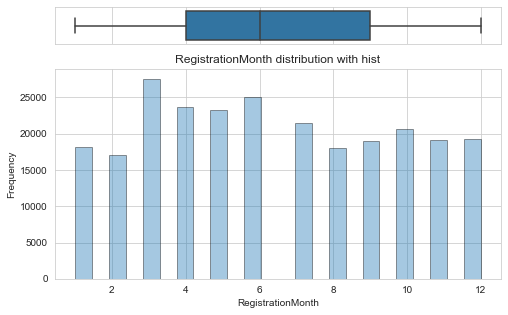

In [32]:
for i in numerical_features:
    plot_hist(df, i)

Теперь распределение признака ***Power*** приближено к нормальному, и мы избавились от нулевого месяца регистрации и сомнительных значений года регистрации авто.

<div class="alert alert-block alert-success">
<b>Успех:</b> Аномалии во всех столбцах найдены и обработаны
</div>

<div class="alert alert-block alert-info">
<b>Совет:</b> Самое интересное, что на нескольких сайтов по продажам подержанных автомобилей в Германии (страну можно определить по почтовым индексам, большинство из них из Германии) показало, что цены начинаются действительно с 0 и 1 евро, но это единичные объявления и не понятно, то ли это ошибка при заполнении формы, то ли машины на металлолом. Но я тоже все-таки склоняюсь к тому, чтобы избавиться от таких данных
</div> 

## EDA

### Взаимосвязь переменных

Построим  матрицы коэффициентов корреляции *Пирсона* и *Спирмена*, что поможет выявить меру линейной связи предстваленных переменных.

Коэффициент корреляции *Пирсона* - $r_{X_i, Y_i}$ для двух переменных $X_i$ и $Y_i$ рассчитывается следующим образом:

\begin{equation*}
r_{X_i, Y_i}=\frac{cov(X_i, Y_i)}{\sigma_{X_i}\sigma_{Y_i}} \
\end{equation*}

где
 - $cov(X_i, Y_i)$ ковариация переменных 
 - $\sigma_{X_i}\sigma_{Y_i}$ седнеквадратическое отклонение для исследуемых признаков

В общем случае для ***n***-мерной выборки, с набором переменных $X_i$ и $Y_i$ для, переведенных в ранговые - $rg_{X_i}, rg_{Y_i}$, коэффициент корреляции *Спирмена* - $r_s$ может быть рассчитан по следующей формуле: 



\begin{equation*}
r_s=r_{rg_{X}, rg_{Y}}=\frac{cov(rg_{X}, rg_{Y})}{\sigma_{rg_{X}}\sigma_{rg_{Y}}} \
\end{equation*}

где
 - $r_{rg_{X}, rg_{Y}}$ - обозначени коэффициент корреляции *Пирсона* для ранговых переменных 
 - $cov(rg_{X}, rg_{Y})$ - ковариация ранговых переменных 
 - $\sigma_{rg_{X}}\sigma_{rg_{Y}}$ - среднеквадратическое отклонение ранговых переменных

In [33]:
def corr_plots(data):
    
    f, ax = plt.subplots(1, 2, figsize=(17, 7))
    
    sns.heatmap(data.corr(method='pearson'),
                vmin=-1,
                vmax=1,
                center=0,
                annot=True,
                cmap='PuBu',
                ax=ax[0])
    
    ax[0].set_title('Pearsons rank correlation coefficient')
    
    sns.heatmap(data.corr(method='spearman'),
                vmin=-1,
                vmax=1,
                center=0,
                annot=True,
                cmap='PuBu',
                ax=ax[1])
    
    ax[1].set_title('Spearmans correlation coefficient')
    
    plt.show()

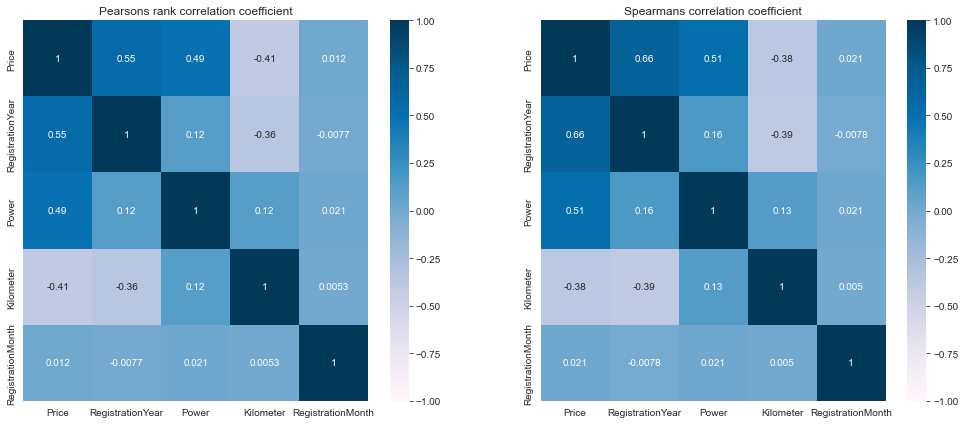

In [34]:
corr_plots(df)

Концентрировать свое внимание будем на взаимосвязи ***Price*** с остальными переменными.

Наиболее интересно выглядит сильная положительная взаимосвязь цены и года регистрации автомобиля, и цены и мощности двигателя. Наблюдаемые показатели взаимосвязи выглядят весьма логично - чем старше машина, тем меньше ее цена вследствие морального и технического устаревания товара, и чем больше мощность представленного автомобиля, тем дороже лот в магазине.

Помимо этого наблюдается обратная взаимосвязь между пробегом и ценой, что так же выглядит весьма правдоподобно - больший пробег соотвествует меньшей цене на авто. 

### Feature Engineering

Создадим несколько категориальных переменных на основе выявленных зависимостей. Начнем ***RegistrationYear***.

In [35]:
high_year_quantile = df['RegistrationYear'].quantile(.75)
low_year_quantile = df['RegistrationYear'].quantile(.25)

In [36]:
def registration_categorisation(year):
    
    if year >= high_year_quantile:
        return 'new'
    
    if year <= low_year_quantile:
        return 'old'
    
    return 'middle'

In [37]:
%%time

df['registration_type'] = df['RegistrationYear'].apply(registration_categorisation)

Wall time: 134 ms


Далее добавим новый признак на основе мощности представленных автомобилей - ***Power***.

In [38]:
high_power_quantile = df['Power'].quantile(.75)
low_power_quantile = df['Power'].quantile(.25)

In [39]:
def power_categorisation(year):
    
    if year >= high_power_quantile:
        return 'powerful'
    
    if year <= low_power_quantile:
        return 'weak'
    
    return 'regular'

In [40]:
%%time

df['power_type'] = df['Power'].apply(power_categorisation)

Wall time: 91.5 ms


Проверим корректность новых категориальных признаков.

In [41]:
df[['RegistrationYear', 'registration_type', 'Power', 'power_type']].sample(n=10, replace=True, random_state=42)

,RegistrationYear,registration_type,Power,power_type
163957,2000,middle,82,regular
199051,2006,middle,200,powerful
177885,1999,old,101,regular
138465,2002,middle,75,weak
161077,2008,new,170,powerful
147622,2003,middle,50,weak
287529,2009,new,140,regular
72154,2008,new,86,regular
185486,2008,new,105,regular
295728,1996,old,140,regular


Добавление новых признаков выполнено верно, двигаемся дальше.

### Оценка факторов цены 

Посмотрим, как зависит цена от других других факторов.

In [42]:
def price_changes(column):
    
    plt.subplots(figsize=(10, 7))
    
    sns.lineplot(x=column,
                 y='Price',
                 n_boot=100,
                 data=df,
                 ci=95)

    plt.title('Confidence interval of Price for any {}'.format(column))
    plt.xlabel(column)
    plt.xticks(rotation = 90)
    plt.ylabel('Price')
    plt.show()

#### VehicleType 

Оценим как меняется цена для различных типов автомобильного кузова. Построим сводную таблицу для данных категорий.

In [43]:
vehicle_type_pivot = df.pivot_table(index='VehicleType',
                                    values='Price',
                                    aggfunc={'Price' : 'mean'}).sort_values(by='Price', ascending=False)

In [44]:
vehicle_type_pivot

,Price
VehicleType,
suv,9177.429018
convertible,6450.548847
coupe,5598.432760
wagon,5184.406899
sedan,4867.931629
bus,4826.692182
other,3859.456334
small,2986.234798


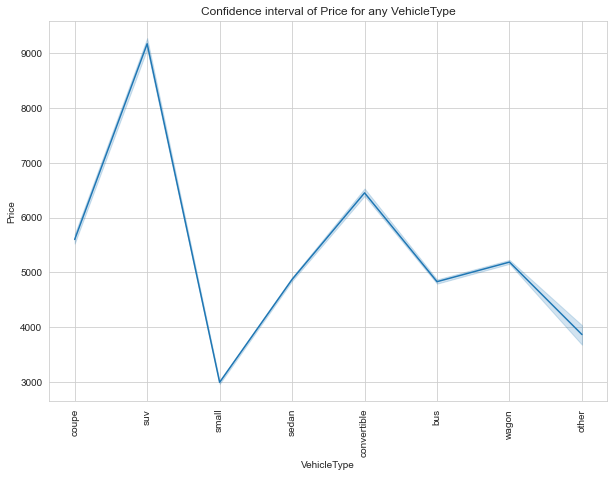

In [45]:
price_changes('VehicleType')

Тип кузова влияет на цену автомобиля - наиболее дорогими являются машины с кузовом **suv** - внедорожники, средняя цена которых составляет **9177 евро**, а самым дешевым типом является **small**.

#### Gearbox 

Посмотрим как средняя цена зависит от типа коробки передач.

In [46]:
gearbox_pivot = df.pivot_table(index='Gearbox',
                               values='Price',
                               aggfunc={'Price' : 'mean'}).sort_values(by='Price', ascending=False)

In [47]:
gearbox_pivot

,Price
Gearbox,
auto,6596.689786
manual,4303.607906


Предсказуемо, машины с автоматической коробкой передач стоят гораздо дороже, чем ручные.

#### FuelType

Как меняется средняя цена на авто в зависимости от типа топлива?

In [48]:
fuel_type_pivot = df.pivot_table(index='FuelType',
                                 values='Price',
                                 aggfunc={'Price' : 'mean'}).sort_values(by='Price', ascending=False)

In [49]:
fuel_type_pivot

,Price
FuelType,
hybrid,9460.163551
gasoline,6764.619950
electric,4694.871690
petrol,3881.623694
lpg,3684.532991
other,3098.611111
cng,2906.599295


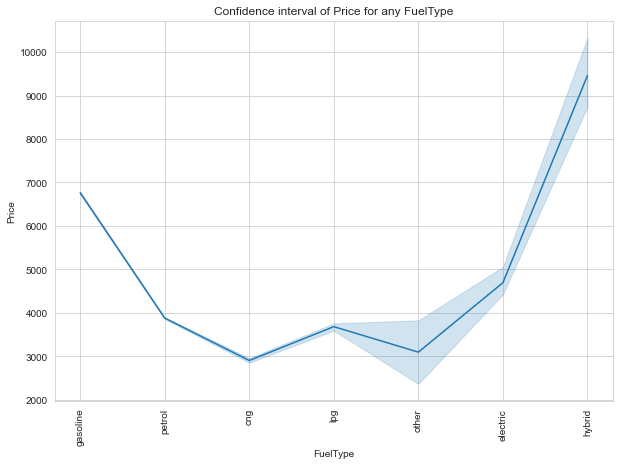

In [50]:
price_changes('FuelType')

Самая высокая средняя цена наблюдается у машин с типом топлива - **hybrid** - **9460 евро**.

#### Brand

Наверняка, можно выделить наиболее дорогие бренды среди остальных. Оценим характер цен для различных марок машин.

In [51]:
brand_pivot = df.pivot_table(index=['Brand'],
                             values='Price',
                             aggfunc={'Price' : 'mean', 'Brand' : 'count'}).sort_values(by='Price', ascending=False)

brand_pivot.columns = ['brand_count', 'Price']

In [52]:
brand_pivot.head()

,brand_count,Price
Brand,,
porsche,182,12048.510989
mini,2719,9180.477749
land_rover,372,8414.642473
jeep,482,7400.817427
audi,21137,6645.199792


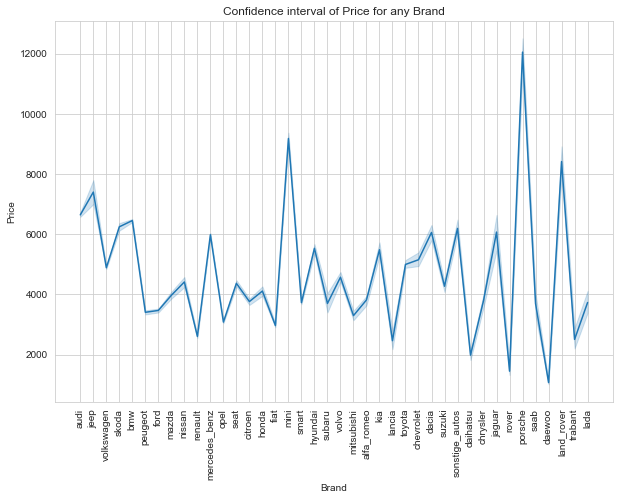

In [53]:
price_changes('Brand')

Самым дорогой маркой автомобиля среди представленных можно считать **porsche** - средняя цена которой составляет **12048 евро**.

#### NotRepaired

Посмотрим как наличие ремонда отразится на средней цене авто.

In [54]:
not_repaired_pivot = df.pivot_table(index='NotRepaired',
                               values='Price',
                               aggfunc={'Price' : 'mean'}).sort_values(by='Price', ascending=False)

In [55]:
not_repaired_pivot

,Price
NotRepaired,
no,5451.382676
yes,2024.738700


Вполне логичным выглядит полученные результаты: авто, которые пришлось ремонтировать в прошлом, стоят в среднем почти в два раза дешевле. 

#### registration_type

Оценим как зависит средняя цена от введенной нами ранее новой категориальной переменной, характерезующей возраст автомобиля.

In [56]:
registration_pivot = df.pivot_table(index='registration_type',
                               values='Price',
                               aggfunc={'Price' : 'mean'}).sort_values(by='Price', ascending=False)

In [57]:
registration_pivot

,Price
registration_type,
new,8941.193077
middle,4107.237725
old,1676.084121


Как отмечалось ранее, на этапе оценки взаимосвязи переменных, более новые машины стоят гораздо дороже подержанных.

#### power_type

Далее посмотрим как меняется средняя цена на машину в зависимости от введенного нами категориального признака по мощности автомобиля.

In [58]:
power_pivot = df.pivot_table(index='power_type',
                               values='Price',
                               aggfunc={'Price' : 'mean'}).sort_values(by='Price', ascending=False)

In [59]:
power_pivot

,Price
power_type,
powerful,7600.416250
regular,4602.551427
weak,2059.530685


Мощность существенно сказывается на ценообразование авто на рынке. Чем мощнее машина, тем, скорее всего, дороже она будет продана.

## Подготовка данных

Итак, выделим основные этапы преобразования данных, под оптимальный для машинного обучения формат:

* Преобразуем категориальные переменные в численные методом **порядкового кодирования** (*Label Encoding*).
* Выделим исследуемый целевой признак среди остальных в наших данных.
* Исходные данные нужно разбить на две части: *обучающую* и *валидационную* выборки в соотношении **3:1**.Выделим тренировочную выборку, составляющую **75%** от исходных данных и валидационную (**25%**).
* Масштабируем признаки.

Оформим все вышеперечисленные этапы в функцию, принимающую в качестве аргумента исследуемый датафрейм.

In [60]:
def data_preparation(df_input):
    
    data = df_input.copy()
    
    categories_features = data.dtypes[data.dtypes=='object'].index
    
    encoder = LabelEncoder()
    
    for col in categories_features:
        data[col] = encoder.fit_transform(data[col])
    
    features = data.drop(['Price'], axis=1)
    target = data['Price']
    
    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                  target,
                                                                                  train_size=.75,
                                                                                  random_state=42)
    print('Размер тренировочной выборки:', features_train.shape)
    print('Размер валидационной выборки:', features_valid.shape)
    
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    return features_train, features_valid, target_train, target_valid

## Обучение моделей

Для оценки качества моделей применим метрику $RMSE$ - **cреднеквадратичная ошибка** (*Root Mean Square Error*). По сути своей - это просто квадратный корень из $MSE$. Квадратный корень введен, чтобы масштаб ошибок был таким же, как масштаб целей. $RMSE$ рассчитывается следующим образом: 

$$
RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y - \hat{y})^2}
$$

где:

* $n$ - размерность выборки 
* $y$ - фактических значение целевой переменной
* $\hat{y}$ - расчетные значения целевого признака

Создадим функцию, осуществляющую поиск наилучшего сочетания гиперпараметров модели вокруг наименьшего значения нашей метрики.

In [61]:
def model_search(data, model, parameters, model_name):
    
    features_train, features_valid, target_train, target_valid = data_preparation(data)
    
    def rmse(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        return rmse
    
    rmse_score = make_scorer(rmse, greater_is_better=False)
    
    grid = GridSearchCV(model,
                        parameters,
                        cv=3,
                        scoring=rmse_score,
                        n_jobs=-1)
    
    start_fit = time.time()
    grid.fit(features_train, target_train)
    end_fit = time.time()
    
    time_fit = round(end_fit - start_fit, 2)
    
    start_pred = time.time()
    predictions = grid.predict(features_valid)
    end_pred = time.time()
    
    time_pred = round(end_pred - start_pred, 4)
    
    best_parameters = grid.best_params_
    best_score_RMSE = round(rmse(target_valid, predictions), 2)
    
    result_list = [best_score_RMSE, time_fit, time_pred]
    
    print('')
    print('Итоги обучения модели:')
    print('')
    print('- Лучшее сочетание гиперпараметров для модели {}: \n  {}'.format(model_name, best_parameters))
    print('')
    print('- RMSE: {}'.format(best_score_RMSE))
    print('')
    print('- Время оптимизации по сетке в секундах: {}'.format(time_fit))
    print('')
    print('- Время предсказания в секундах: {}'.format(time_pred))
    
    f, ax = plt.subplots(1, 2, figsize=(15, 6))
        
    lims = [0, target_valid.max()]

    ax[0].set_title('Errors estimation')
    sns.scatterplot(target_valid,
                    predictions,
                    alpha=.2,
                    ax=ax[0])
    sns.lineplot(lims,
                 lims,
                 color='red',
                 linewidth=2.5,
                 ax=ax[0]).lines[0].set_linestyle('--')
    ax[0].set_xlabel('True values')
    ax[0].set_ylabel('Predicted')
    
    error = predictions - target_valid
    
    ax[1].set_title('Errors distribution')
    sns.distplot(error,
                 hist=True,
                 kde=True, 
                 bins=50,
                 hist_kws={'edgecolor':'black'},
                 ax=ax[1])
    ax[1].set_xlabel('Prediction Error')
    ax[1].set_ylabel('Density')
    
    plt.show()
    
    return result_list, best_parameters

### LinearRegression

Обучим тестовую модель - линейную регресси.

In [62]:
lin_reg = LinearRegression()

Зададим гиперпараметры для оптимизации по сетке. 

In [63]:
param_lr = {'fit_intercept':[True, False],
            'normalize':[True, False],
            'copy_X':[True, False]}

Размер тренировочной выборки: (189373, 12)
Размер валидационной выборки: (63125, 12)

Итоги обучения модели:

- Лучшее сочетание гиперпараметров для модели LinearRegression: 
  {'copy_X': True, 'fit_intercept': True, 'normalize': True}

- RMSE: 2782.33

- Время оптимизации по сетке в секундах: 2.77

- Время предсказания в секундах: 0.002


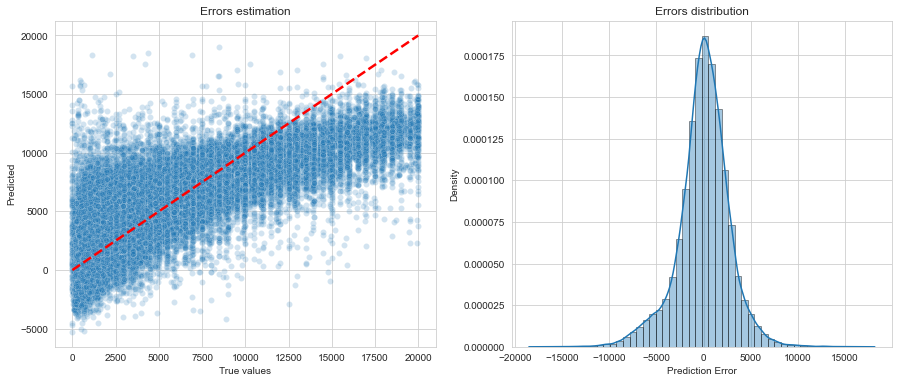

Wall time: 3.99 s


In [64]:
%%time

lin_reg_result_list, lin_reg_best_parameters = model_search(df, lin_reg, param_lr,'LinearRegression')

### DecisionTreeRegressor

Опробуем модель **дерева решений для задачи регрессии**.

In [65]:
tree = DecisionTreeRegressor(random_state=42)

In [66]:
param_tree = {'max_depth':[5, 10, 15], 
              'min_samples_split':[5, 7, 9], 
              'min_samples_leaf':[3, 5, 7]}

Размер тренировочной выборки: (189373, 12)
Размер валидационной выборки: (63125, 12)

Итоги обучения модели:

- Лучшее сочетание гиперпараметров для модели DecisionTreeRegressor: 
  {'max_depth': 15, 'min_samples_leaf': 7, 'min_samples_split': 5}

- RMSE: 1714.99

- Время оптимизации по сетке в секундах: 6.72

- Время предсказания в секундах: 0.0125


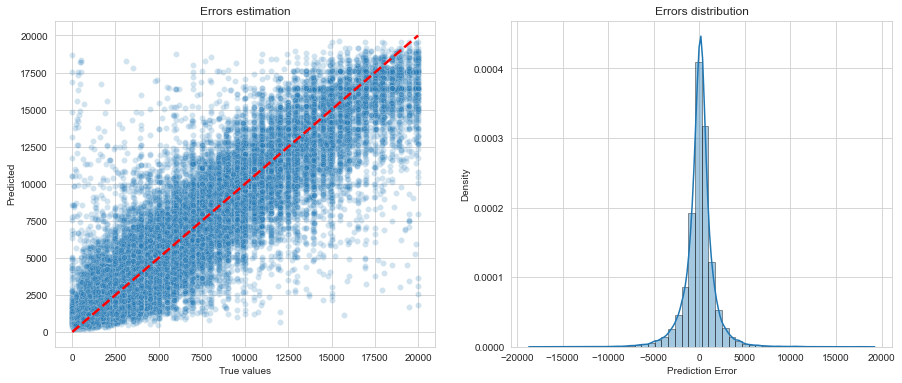

Wall time: 8.04 s


In [67]:
%%time

tree_result_list, tree_best_parameters = model_search(df,tree,param_tree,'DecisionTreeRegressor')

### RandomForestRegressor

Зададим модель **случайного леса для задачи регрессии**.

In [68]:
forest = RandomForestRegressor(random_state=42)

In [69]:
param_forest = {'max_depth':[10, 15],
                'min_samples_split':[5, 7],
                'max_features': ['auto', 'sqrt'],
                'bootstrap': [True]}

Размер тренировочной выборки: (189373, 12)
Размер валидационной выборки: (63125, 12)

Итоги обучения модели:

- Лучшее сочетание гиперпараметров для модели RandomForestRegressor: 
  {'bootstrap': True, 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 5}

- RMSE: 1555.07

- Время оптимизации по сетке в секундах: 122.92

- Время предсказания в секундах: 1.0414


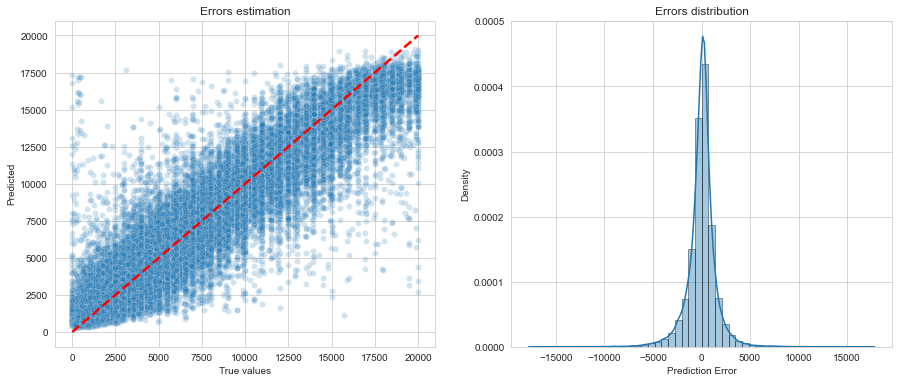

Wall time: 2min 5s


In [70]:
%%time

forest_result_list, forest_best_parameters = model_search(df,forest,param_forest,'RandomForestRegressor')

###  LGBMRegressor

Обучим модель **LGBMRegressor**.

In [71]:
lgbm = LGBMRegressor(random_state=42, silent=True)

Определим гиперпараметры.

In [72]:
params_lgbm = {'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
               'n_estimators': [100, 300, 500, 1000, 1500, 3000]}

Размер тренировочной выборки: (189373, 12)
Размер валидационной выборки: (63125, 12)

Итоги обучения модели:

- Лучшее сочетание гиперпараметров для модели LGBMRegressor: 
  {'learning_rate': 0.1, 'n_estimators': 1500}

- RMSE: 1453.14

- Время оптимизации по сетке в секундах: 323.96

- Время предсказания в секундах: 0.5668


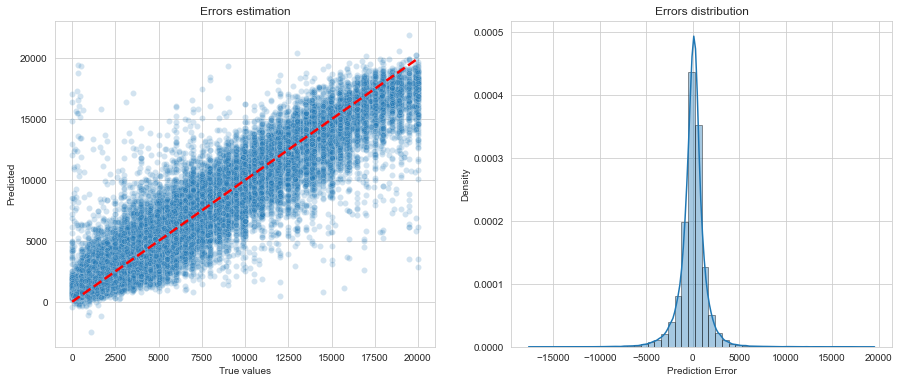

Wall time: 5min 25s


In [73]:
%%time

lgbm_result_list, lgbm_best_parameters = model_search(df,
                                                      lgbm,
                                                      params_lgbm,
                                                      'LGBMRegressor')

## Анализ моделей

Оформим сводную таблицу по итогам обучения разлиных моделей.

In [74]:
dict = {'LinearRegression' : lin_reg_result_list,
        'DecisionTreeRegressor' : tree_result_list,
        'RandomForestRegressor' : forest_result_list,
        'LGBMRegressor' : lgbm_result_list}

result_tab = pd.DataFrame.from_dict(dict,
                                    orient='index',
                                    columns=['RMSE', 'Fit Time', 'Prediction Time']).sort_values(by='RMSE')
result_tab

,RMSE,Fit Time,Prediction Time
LGBMRegressor,1453.14,323.96,0.5668
RandomForestRegressor,1555.07,122.92,1.0414
DecisionTreeRegressor,1714.99,6.72,0.0125
LinearRegression,2782.33,2.77,0.0020


Таким образом, лучшего всего показала себя модель **LGBMRegressor**. Ее показатель метрики равен **1452**, а общее время обучение составило **324 секунды** или же около **5 минут 24 секунд**.

## Общий вывод

Исходные данные содержали пропуски и дубликаты, которые были обработаны в рамках препоцессинга. Для пропусков в различных категориальных переменных был выбран индивидуальный подход заполнения на основе остальных признаков. От дубликатов же мы избавились, так как их общее количество было крайне мало.

Помимо прочего мы обработали данные с точки зрения наличия в них выбросов и аномальных значений. Так, например, в признаке ***Price*** при помощи построения гистограммы и ящика с усами обнаружились нулевые значения, которые в последствие могли бы помешать корректной работе алгоритма машинного обучения. Таким же образом мы избавились от нулевых значений в признаке ***Power*** - мощности представленного автомобиля и в переменной ***RegistrationMonth***, где были метки нулевого месяца регистрации.

В добавок, признак ***Power*** ввиду наличия выбросов было решено ограничить полуторным интерквартильным размахом. Аналогичный подход был реализован для переменной ***RegistrationYear***. По итогам реализации данного подхода распределение вышеназванных признаков приблизилось к нормальному.

Была произведена оценка взаимосвязи переменных. Удалось выяснить, что цена сильнее всего зависит от года регистрации автомобиля - **0.55** по *Пирсону* и **0.66** по *Спирмену* и от мощности двигателя - **0.49** по *Пирсону* и **0.51** по *Спирмену*.

Далее на основе корреляционного анализа мы ввели новые категориальные переменные на основе года регистрации - ***registration_type***, где все объектам исходного датафрейма были присвоены категории - **new**, **middle** или **old**, и на основе мощности автомобиля - ***power_type*** с категориями - **weak**, **regular** и **powerful**.

Также была произведена оценка факторов влияния цены. Автомобили с типом кузова **suv** обладают самой высокой средней ценой - **9177 евро**. Самые дороги авто обладают типом коробки передач **auto** - средняя цена на оные составляет **6597 евро**. Машины с типом топлива **hybrid** имею самую высотку среднею цену - **9460 евро**. Самым дорогим бредом автомобиля является **porsche** со средней ценой в **12048 евро**. Машины прошедшие ремонт предсказуемо продаются за меньшую цену. В зависимости от введенных нами категорий, возраста и мощности, мы выявили, что средняя цена гораздо выше у более новых и мощных автомобилей, чем у старых и маломощных.

Было обучено несколько моделей машинного обучения:

 * **LinearRegression**
 * **DecisionTreeRegressor**
 * **RandomForestRegressor**
 * **LGBMRegressor**

В качестве метрики оценки качества использовалась $RMSE$. Наилучший показатель оной был зафиксирован у алгоритма **LGBMRegressor** со значением метрики **1452** и временем обучения в **5 минут 24 секунд**.